# 03. モデル評価指標 (Model Evaluation Metrics)

## 概要
機械学習モデルの性能を正しく評価する方法を学びます。

## 学習目標
- 分類問題の評価指標を理解できる
- 回帰問題の評価指標を理解できる
- 混同行列とROC曲線を作成できる
- クロスバリデーションを実行できる
- 学習曲線を分析できる

In [ ]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score, auc,
    mean_squared_error, mean_absolute_error, r2_score
)

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans',      # macOS
        'Hiragino Maru Gothic Pro',  # macOS
        'AppleGothic',        # macOS
        'Yu Gothic',          # Windows
        'MS Gothic',          # Windows
        'Noto Sans CJK JP',   # Linux
        'IPAexGothic',        # Linux
        'TakaoPGothic',       # Linux
    ]
    
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    
    print("Warning: Japanese font not found. Some text may not display correctly.")
    return None

# フォント設定を実行
font_used = setup_japanese_font()
np.random.seed(42)

print("Setup complete")
if font_used:
    print(f"Japanese font: {font_used}")

## 1. 分類問題の評価指標

### 基本的な指標

分類問題では、予測がどれだけ正確かを測る必要があります。

**主な評価指標:**

1. **正解率（Accuracy）**
   - 全予測のうち、正しく分類した割合
   - 式: (TP + TN) / (TP + TN + FP + FN)
   - データが不均衡だと誤解を招く

2. **適合率（Precision）**
   - 陽性と予測したうち、実際に陽性だった割合
   - 式: TP / (TP + FP)
   - 偽陽性を減らしたい場合に重視

3. **再現率（Recall）**
   - 実際の陽性のうち、正しく予測できた割合
   - 式: TP / (TP + FN)
   - 偽陰性を減らしたい場合に重視

4. **F1スコア**
   - PrecisionとRecallの調和平均
   - 式: 2 × (Precision × Recall) / (Precision + Recall)
   - バランスの取れた指標

In [52]:
# 分類データ生成
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_classes=2,
    weights=[0.7, 0.3],  # 不均衡データ
    random_state=42
)

# データ分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# モデル学習
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# 予測
y_pred = model.predict(X_test)

# 評価指標の計算
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("分類評価指標:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")

print(f"\nクラス分布（テスト）: {np.bincount(y_test)}")

分類評価指標:
  Accuracy:  0.8500
  Precision: 0.7719
  Recall:    0.7213
  F1 Score:  0.7458

クラス分布（テスト）: [139  61]


## 2. 混同行列（Confusion Matrix）

### 混同行列とは

予測と実際のクラスの関係を表にしたものです。

```
                予測
          Negative  Positive
実際 Neg     TN        FP
     Pos     FN        TP
```

- **TP (True Positive)**: 正しく陽性と予測
- **TN (True Negative)**: 正しく陰性と予測
- **FP (False Positive)**: 間違って陽性と予測（第1種の誤り）
- **FN (False Negative)**: 間違って陰性と予測（第2種の誤り）

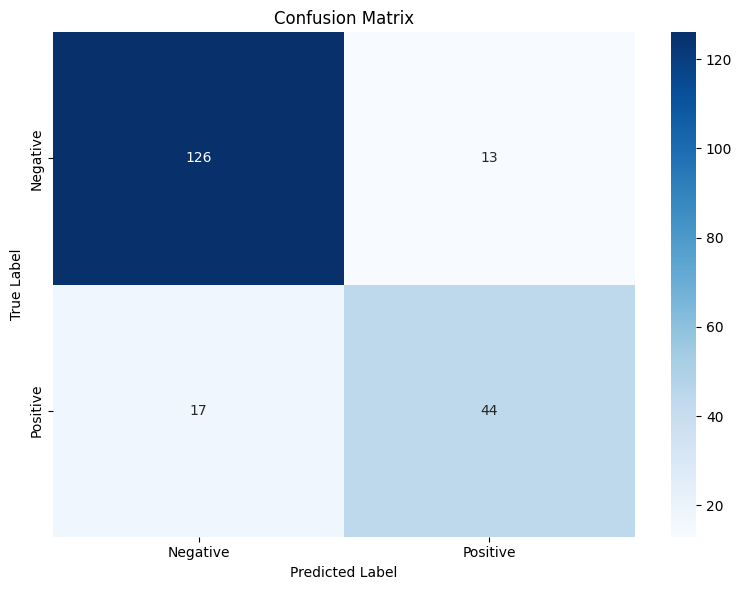

混同行列:
[[126  13]
 [ 17  44]]

True Negatives:  126
False Positives: 13
False Negatives: 17
True Positives:  44


In [53]:
# 混同行列の計算と可視化
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print("混同行列:")
print(cm)
print(f"\nTrue Negatives:  {cm[0, 0]}")
print(f"False Positives: {cm[0, 1]}")
print(f"False Negatives: {cm[1, 0]}")
print(f"True Positives:  {cm[1, 1]}")

In [54]:
# 詳細な分類レポート
print("\n詳細な分類レポート:")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))


詳細な分類レポート:
              precision    recall  f1-score   support

     Class 0       0.88      0.91      0.89       139
     Class 1       0.77      0.72      0.75        61

    accuracy                           0.85       200
   macro avg       0.83      0.81      0.82       200
weighted avg       0.85      0.85      0.85       200



## 3. ROC曲線とAUC

### ROC曲線とは

**ROC (Receiver Operating Characteristic) 曲線**は、分類器の性能を可視化する方法です。

### 閾値（しきい値）の概念

分類モデルは「このサンプルが陽性である確率」を出力します（例: 0.73）。この確率をもとに最終的な予測（陽性 or 陰性）を決めるには、**閾値（threshold）**が必要です。

```
例: 閾値 = 0.5 の場合
  確率 0.73 → 0.5以上なので「陽性」と予測
  確率 0.32 → 0.5未満なので「陰性」と予測
```

**閾値を変えると予測結果が変わります：**
- 閾値を**下げる**（例: 0.3）→ 陽性と判定されやすくなる → TPもFPも増加
- 閾値を**上げる**（例: 0.7）→ 陽性と判定されにくくなる → TPもFPも減少

### ROC曲線の作り方

ROC曲線は、**閾値を0から1まで動かしながら**、各閾値での以下の2つの値をプロットしたものです：

- **Y軸: 真陽性率（TPR）** = TP / (TP + FN)
  - 実際の陽性のうち、正しく陽性と予測できた割合（= Recall）

- **X軸: 偽陽性率（FPR）** = FP / (FP + TN)
  - 実際の陰性のうち、間違って陽性と予測してしまった割合

### なぜ横軸が偽陽性率なのか？

閾値を下げると、陽性と判定しやすくなるため：
- **良いこと**: 本当の陽性をより多く見つけられる（TPR↑）
- **悪いこと**: 陰性も間違って陽性と判定してしまう（FPR↑）

つまり、TPRとFPRには**トレードオフ**の関係があります。

**良い分類器**とは、FPR（誤検知）を低く抑えながら、TPR（検出率）を高くできる分類器です。グラフでは**左上**に曲線が寄るほど良い分類器です。

### AUC (Area Under the Curve)

ROC曲線の下の面積です。

- **AUC = 1.0**: 完璧な分類器（左上の角を通る）
- **AUC = 0.5**: ランダムな分類器（対角線）
- **AUC < 0.5**: ランダムより悪い（特徴量の解釈が逆？）

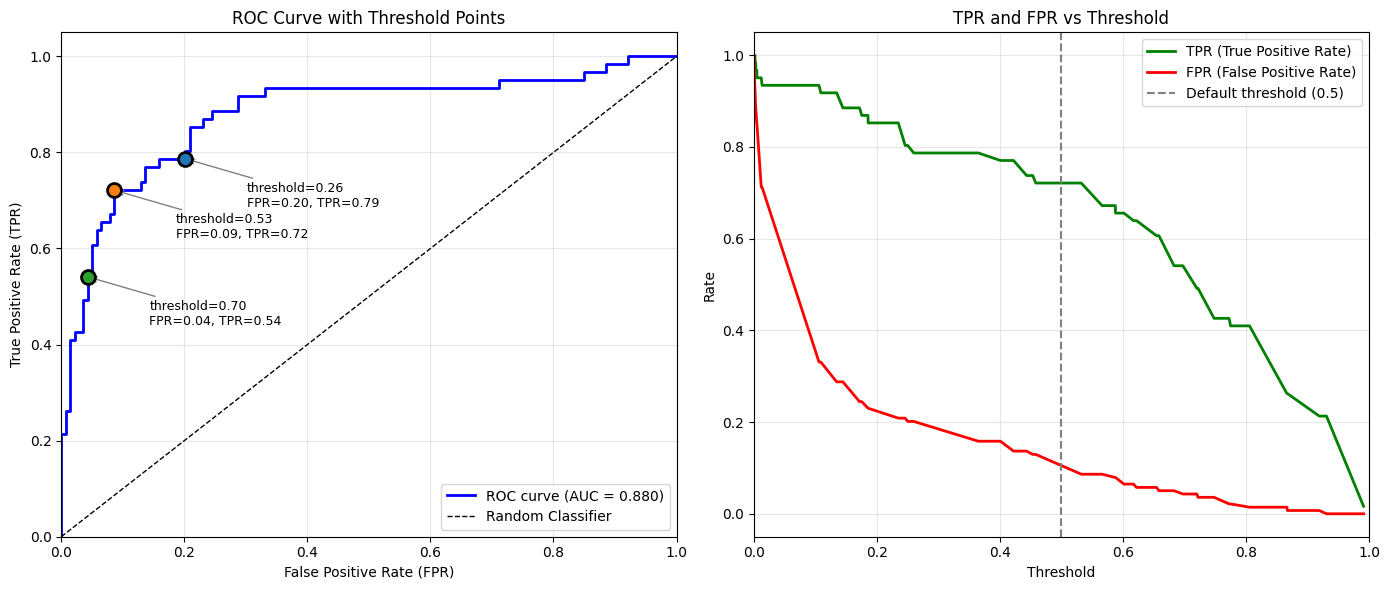

AUC Score: 0.8803

【解釈】
・左図: ROC曲線上の各点は異なる閾値に対応しています
・右図: 閾値を下げる（左へ）とTPRもFPRも上昇します
・閾値0.5付近で両者のバランスが取れることが多いです


In [55]:
# ROC曲線の計算
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# 可視化（閾値のポイントも表示）
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 左: ROC曲線（閾値のポイント付き）
ax1 = axes[0]
ax1.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

# 代表的な閾値のポイントをマーク
threshold_points = [0.3, 0.5, 0.7]
for thresh in threshold_points:
    idx = np.argmin(np.abs(thresholds - thresh))
    ax1.scatter(fpr[idx], tpr[idx], s=100, zorder=5, edgecolors='black', linewidth=2)
    ax1.annotate(f'threshold={thresholds[idx]:.2f}\nFPR={fpr[idx]:.2f}, TPR={tpr[idx]:.2f}',
                 xy=(fpr[idx], tpr[idx]), xytext=(fpr[idx]+0.1, tpr[idx]-0.1),
                 fontsize=9, arrowprops=dict(arrowstyle='->', color='gray'))

ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate (FPR)')
ax1.set_ylabel('True Positive Rate (TPR)')
ax1.set_title('ROC Curve with Threshold Points')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# 右: 閾値とTPR/FPRの関係
ax2 = axes[1]
ax2.plot(thresholds, tpr, 'g-', linewidth=2, label='TPR (True Positive Rate)')
ax2.plot(thresholds, fpr, 'r-', linewidth=2, label='FPR (False Positive Rate)')
ax2.axvline(x=0.5, color='gray', linestyle='--', label='Default threshold (0.5)')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Rate')
ax2.set_title('TPR and FPR vs Threshold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 1])  # 閾値の範囲を0-1に制限

plt.tight_layout()
plt.show()

print(f"AUC Score: {roc_auc:.4f}")
print("\n【解釈】")
print("・左図: ROC曲線上の各点は異なる閾値に対応しています")
print("・右図: 閾値を下げる（左へ）とTPRもFPRも上昇します")
print("・閾値0.5付近で両者のバランスが取れることが多いです")

## 4. 回帰問題の評価指標

### 回帰問題とは

回帰問題では、連続値（例: 価格、温度、売上）を予測します。予測がどれだけ「正解に近いか」を測る必要があります。

### 誤差（Error）の基本概念

```
誤差 = 実際の値 - 予測値
```

例えば、実際の価格が100万円、予測が90万円なら、誤差は+10万円（過小予測）です。

### 主な評価指標

#### 1. 平均二乗誤差（MSE: Mean Squared Error）
- **式**: Σ(実際 - 予測)² / n
- **特徴**: 誤差を二乗するため、**大きな誤差に敏感**
- **単位**: 元のデータの二乗（解釈しにくい）
- **使いどころ**: 大きな予測ミスを特に避けたい場合

#### 2. 平均二乗平方根誤差（RMSE: Root Mean Squared Error）
- **式**: √MSE
- **特徴**: MSEの平方根を取ることで、**元のデータと同じ単位**になる
- **解釈**: 「平均的に±○○くらいの誤差」と直感的に理解できる
- **使いどころ**: 最も一般的に使われる指標

#### 3. 平均絶対誤差（MAE: Mean Absolute Error）
- **式**: Σ|実際 - 予測| / n
- **特徴**: 絶対値を使うため、**外れ値に頑健**
- **解釈**: 「平均的に±○○くらいの誤差」
- **使いどころ**: 外れ値が多いデータ、すべての誤差を平等に扱いたい場合

#### 4. 決定係数（R²: R-squared）
- **式**: 1 - (予測誤差の分散 / 実際の値の分散)
- **範囲**: 通常0〜1（負の値も可能）
- **解釈**: 「モデルがデータの変動をどれだけ説明できているか」の割合
- **R² = 1.0**: 完璧な予測
- **R² = 0.0**: 平均値で予測するのと同程度
- **R² < 0**: 平均値より悪い予測

### MSE vs MAE: 外れ値への感度の違い

```
データ: [10, 12, 11, 100]  ← 100は外れ値
予測:   [10, 10, 10, 10]

各誤差:  [0, 2, 1, 90]

MAE = (0 + 2 + 1 + 90) / 4 = 23.25
MSE = (0 + 4 + 1 + 8100) / 4 = 2026.25  ← 外れ値の影響が大きい
```

In [56]:
# 回帰データ生成
X_reg, y_reg = make_regression(
    n_samples=1000,
    n_features=10,
    noise=20,
    random_state=42
)

# データ分割
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# モデル学習
reg_model = LinearRegression()
reg_model.fit(X_train_reg, y_train_reg)

# 予測
y_pred_reg = reg_model.predict(X_test_reg)

# 評価指標の計算
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print("回帰評価指標:")
print(f"  MSE:  {mse:.4f}")
print(f"  RMSE: {rmse:.4f}  ← 「平均的に ±{rmse:.1f} 程度の誤差」と解釈できる")
print(f"  MAE:  {mae:.4f}  ← 「平均的に ±{mae:.1f} 程度の誤差」と解釈できる")
print(f"  R²:   {r2:.4f}   ← 「データの変動の {r2*100:.1f}% を説明できている」と解釈できる")

回帰評価指標:
  MSE:  380.4766
  RMSE: 19.5058  ← 「平均的に ±19.5 程度の誤差」と解釈できる
  MAE:  15.5467  ← 「平均的に ±15.5 程度の誤差」と解釈できる
  R²:   0.9774   ← 「データの変動の 97.7% を説明できている」と解釈できる


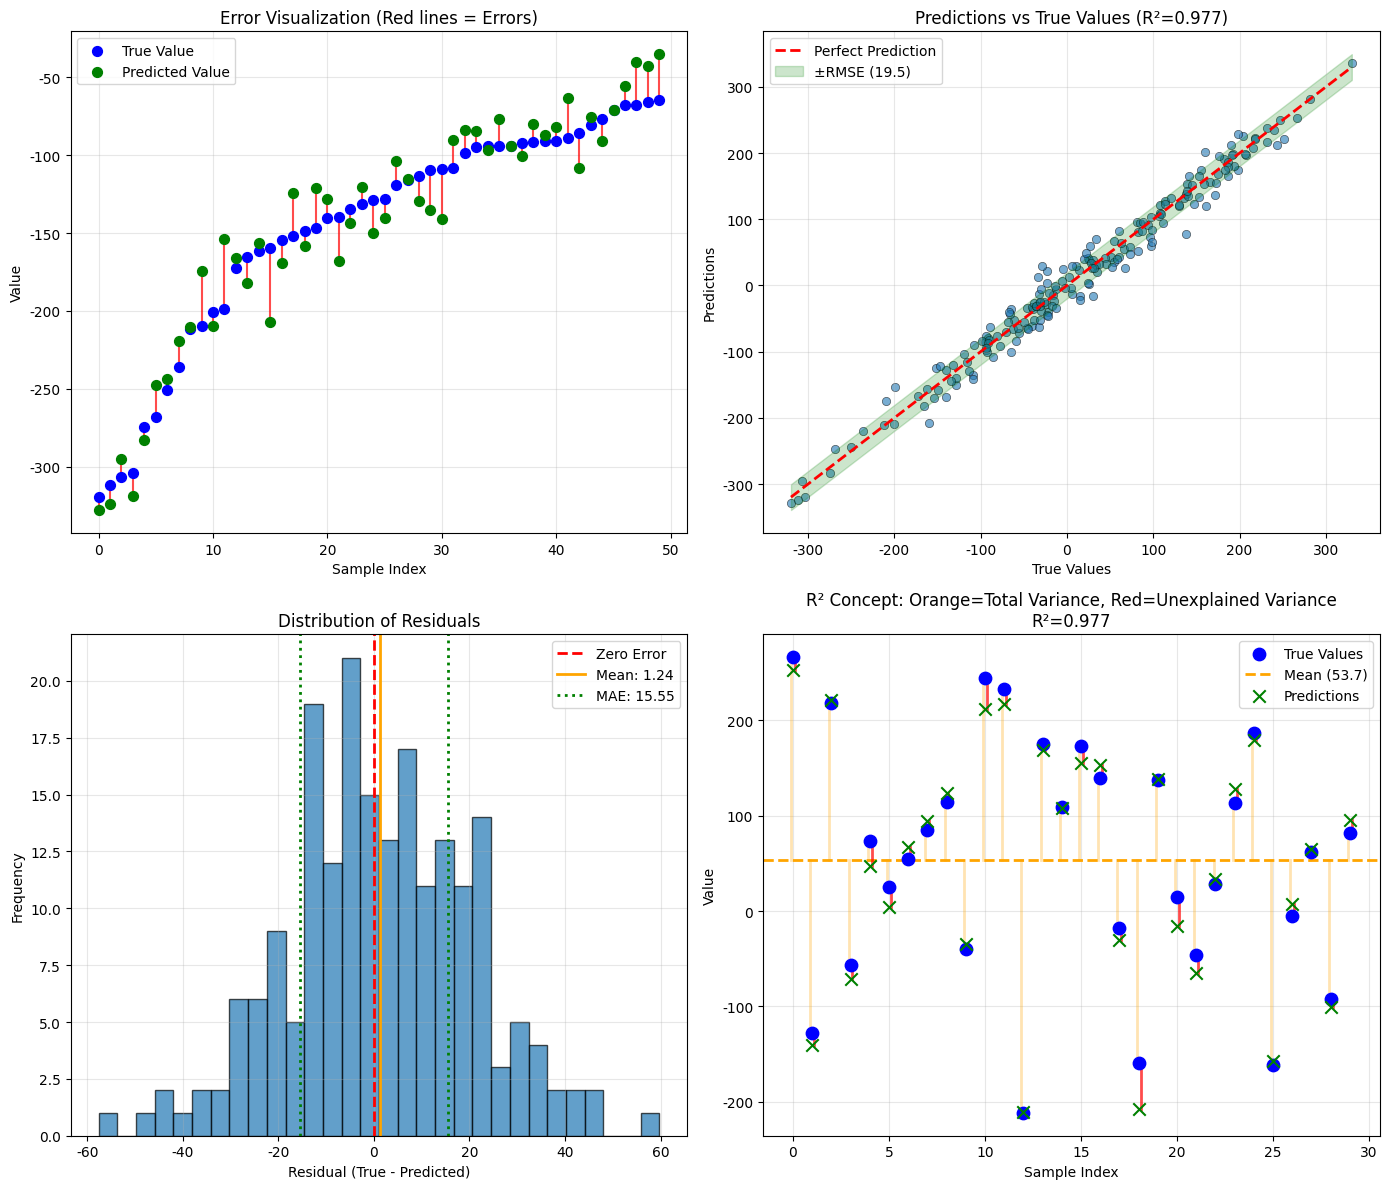

【図の解釈】
・左上: 赤い線が予測誤差。線が短いほど予測が正確
・右上: 点が対角線に近いほど良い予測。緑の帯は±RMSEの範囲
・左下: 残差の分布。0を中心に対称なら偏りのない予測
・右下: R²の概念図。オレンジ=全体の変動、赤=モデルが説明できなかった部分


In [57]:
# 誤差の視覚化: 予測値 vs 実測値 + 誤差を線で表示
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. 予測値 vs 実測値（誤差を視覚化）
ax1 = axes[0, 0]
# ソートしてプロット
sort_idx = np.argsort(y_test_reg)[:50]  # 最初の50点だけ表示
for i, idx in enumerate(sort_idx):
    ax1.plot([i, i], [y_test_reg[idx], y_pred_reg[idx]], 'r-', alpha=0.7, linewidth=1.5)
ax1.scatter(range(len(sort_idx)), y_test_reg[sort_idx], color='blue', s=50, label='True Value', zorder=5)
ax1.scatter(range(len(sort_idx)), y_pred_reg[sort_idx], color='green', s=50, label='Predicted Value', zorder=5)
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Value')
ax1.set_title('Error Visualization (Red lines = Errors)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 予測 vs 実測の散布図
ax2 = axes[0, 1]
ax2.scatter(y_test_reg, y_pred_reg, alpha=0.6, edgecolors='k', linewidth=0.5)
ax2.plot([y_test_reg.min(), y_test_reg.max()], 
         [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2, label='Perfect Prediction')
ax2.fill_between([y_test_reg.min(), y_test_reg.max()],
                 [y_test_reg.min() - rmse, y_test_reg.max() - rmse],
                 [y_test_reg.min() + rmse, y_test_reg.max() + rmse],
                 alpha=0.2, color='green', label=f'±RMSE ({rmse:.1f})')
ax2.set_xlabel('True Values')
ax2.set_ylabel('Predictions')
ax2.set_title(f'Predictions vs True Values (R²={r2:.3f})')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. 残差の分布（ヒストグラム）
ax3 = axes[1, 0]
residuals = y_test_reg - y_pred_reg
ax3.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
ax3.axvline(x=np.mean(residuals), color='orange', linestyle='-', linewidth=2, 
            label=f'Mean: {np.mean(residuals):.2f}')
ax3.axvline(x=mae, color='green', linestyle=':', linewidth=2, label=f'MAE: {mae:.2f}')
ax3.axvline(x=-mae, color='green', linestyle=':', linewidth=2)
ax3.set_xlabel('Residual (True - Predicted)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Residuals')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. R²の視覚的説明
ax4 = axes[1, 1]
# 一部のデータで説明
sample_size = 30
sample_idx = np.random.choice(len(y_test_reg), sample_size, replace=False)
y_sample = y_test_reg[sample_idx]
y_pred_sample = y_pred_reg[sample_idx]
y_mean = np.mean(y_sample)

x_positions = np.arange(sample_size)
ax4.scatter(x_positions, y_sample, color='blue', s=80, label='True Values', zorder=5)
ax4.axhline(y=y_mean, color='orange', linestyle='--', linewidth=2, label=f'Mean ({y_mean:.1f})')
ax4.scatter(x_positions, y_pred_sample, color='green', s=80, marker='x', label='Predictions', zorder=5)

# 全分散（平均からの距離）を薄く表示
for i, (x, y) in enumerate(zip(x_positions, y_sample)):
    ax4.plot([x-0.1, x-0.1], [y_mean, y], 'orange', alpha=0.3, linewidth=2)

# 残差（予測からの距離）を強調表示
for i, (x, y_true, y_pred) in enumerate(zip(x_positions, y_sample, y_pred_sample)):
    ax4.plot([x+0.1, x+0.1], [y_pred, y_true], 'red', alpha=0.7, linewidth=2)

ax4.set_xlabel('Sample Index')
ax4.set_ylabel('Value')
ax4.set_title(f'R² Concept: Orange=Total Variance, Red=Unexplained Variance\nR²={r2:.3f}')
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("【図の解釈】")
print("・左上: 赤い線が予測誤差。線が短いほど予測が正確")
print("・右上: 点が対角線に近いほど良い予測。緑の帯は±RMSEの範囲")
print("・左下: 残差の分布。0を中心に対称なら偏りのない予測")
print("・右下: R²の概念図。オレンジ=全体の変動、赤=モデルが説明できなかった部分")

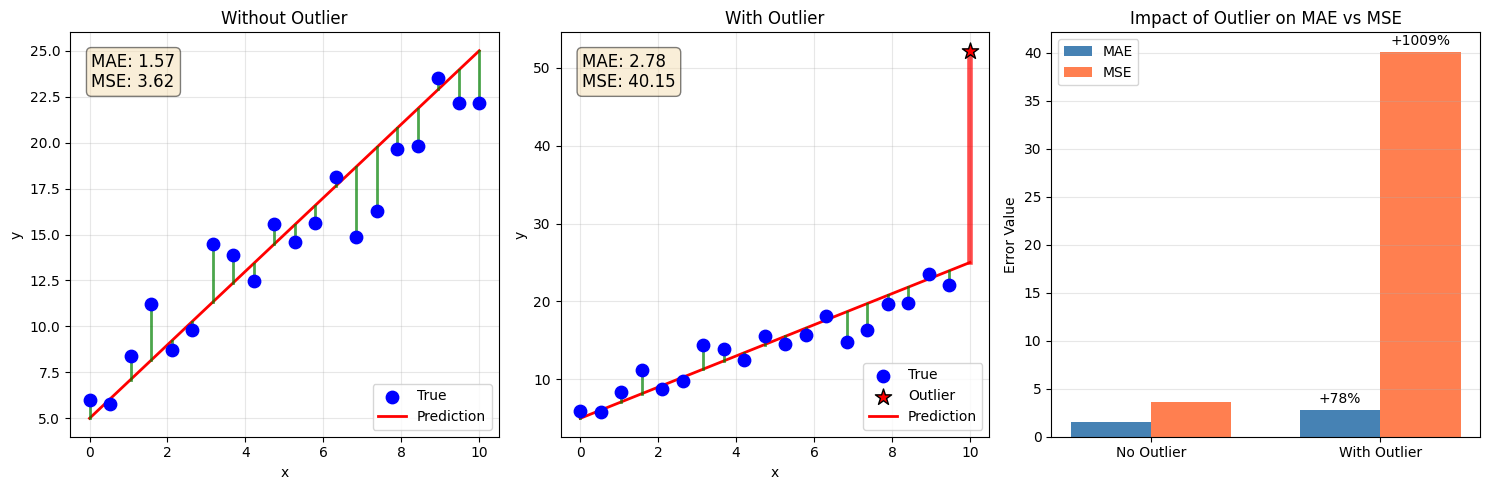

【解釈】
・外れ値1つの追加で、MAEは 78% 増加
・外れ値1つの追加で、MSEは 1009% 増加
・MSEは誤差を二乗するため、大きな誤差の影響を強く受ける
・外れ値が多いデータではMAEの方が安定した評価ができる


In [58]:
# MSE vs MAE: 外れ値への感度の違いを視覚的に比較
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# シンプルな例を作成
np.random.seed(42)
n_points = 20
x_simple = np.linspace(0, 10, n_points)
y_true_simple = 2 * x_simple + 5 + np.random.normal(0, 2, n_points)
y_pred_simple = 2 * x_simple + 5  # 完璧な線形予測

# 外れ値を追加したバージョン
y_true_outlier = y_true_simple.copy()
y_true_outlier[-1] = y_true_outlier[-1] + 30  # 最後の点を外れ値に

# 1. 外れ値なしの場合
ax1 = axes[0]
errors_normal = np.abs(y_true_simple - y_pred_simple)
ax1.scatter(x_simple, y_true_simple, color='blue', s=80, label='True', zorder=5)
ax1.plot(x_simple, y_pred_simple, 'r-', linewidth=2, label='Prediction')
for i in range(n_points):
    ax1.plot([x_simple[i], x_simple[i]], [y_true_simple[i], y_pred_simple[i]], 
             'g-', alpha=0.7, linewidth=2)
ax1.set_title('Without Outlier')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend()
ax1.grid(True, alpha=0.3)

mae_normal = np.mean(np.abs(y_true_simple - y_pred_simple))
mse_normal = np.mean((y_true_simple - y_pred_simple)**2)
ax1.text(0.05, 0.95, f'MAE: {mae_normal:.2f}\nMSE: {mse_normal:.2f}', 
         transform=ax1.transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. 外れ値ありの場合
ax2 = axes[1]
ax2.scatter(x_simple[:-1], y_true_outlier[:-1], color='blue', s=80, label='True', zorder=5)
ax2.scatter(x_simple[-1], y_true_outlier[-1], color='red', s=150, marker='*', 
            label='Outlier', zorder=5, edgecolors='black')
ax2.plot(x_simple, y_pred_simple, 'r-', linewidth=2, label='Prediction')
for i in range(n_points):
    color = 'red' if i == n_points-1 else 'g'
    lw = 4 if i == n_points-1 else 2
    ax2.plot([x_simple[i], x_simple[i]], [y_true_outlier[i], y_pred_simple[i]], 
             color=color, alpha=0.7, linewidth=lw)
ax2.set_title('With Outlier')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.legend()
ax2.grid(True, alpha=0.3)

mae_outlier = np.mean(np.abs(y_true_outlier - y_pred_simple))
mse_outlier = np.mean((y_true_outlier - y_pred_simple)**2)
ax2.text(0.05, 0.95, f'MAE: {mae_outlier:.2f}\nMSE: {mse_outlier:.2f}', 
         transform=ax2.transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. 比較棒グラフ
ax3 = axes[2]
x_bar = np.arange(2)
width = 0.35

# 増加率を計算
mae_increase = (mae_outlier - mae_normal) / mae_normal * 100
mse_increase = (mse_outlier - mse_normal) / mse_normal * 100

bars1 = ax3.bar(x_bar - width/2, [mae_normal, mae_outlier], width, label='MAE', color='steelblue')
bars2 = ax3.bar(x_bar + width/2, [mse_normal, mse_outlier], width, label='MSE', color='coral')

ax3.set_ylabel('Error Value')
ax3.set_title('Impact of Outlier on MAE vs MSE')
ax3.set_xticks(x_bar)
ax3.set_xticklabels(['No Outlier', 'With Outlier'])
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 増加率をアノテーション
ax3.annotate(f'+{mae_increase:.0f}%', xy=(1-width/2, mae_outlier), 
             xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10)
ax3.annotate(f'+{mse_increase:.0f}%', xy=(1+width/2, mse_outlier), 
             xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("【解釈】")
print(f"・外れ値1つの追加で、MAEは {mae_increase:.0f}% 増加")
print(f"・外れ値1つの追加で、MSEは {mse_increase:.0f}% 増加")
print("・MSEは誤差を二乗するため、大きな誤差の影響を強く受ける")
print("・外れ値が多いデータではMAEの方が安定した評価ができる")

## 5. クロスバリデーション

### クロスバリデーションとは

データを複数の分割（フォールド）に分け、それぞれを順番にテストデータとして使用する手法です。

**利点:**
- より信頼性の高い評価
- データの使用効率が良い
- 過学習の検出

### k-Fold Cross Validation

データをk個に分割し、k回の訓練・評価を行います。

In [59]:
from sklearn.model_selection import cross_validate

# 注意: このセクションでは分類データ (X, y) を使用します
# 回帰問題のセルを実行した後にこのセルを実行する場合は、
# cell-3（分類データ生成）を先に再実行してください

# 分類データが正しく読み込まれているか確認
if not isinstance(y, np.ndarray) or y.ndim == 0 or len(np.unique(y)) > 10:
    print("⚠ 分類データを再生成します（回帰データが読み込まれていた可能性があります）")
    X, y = make_classification(
        n_samples=1000, n_features=20, n_informative=10, n_redundant=5,
        n_classes=2, weights=[0.7, 0.3], random_state=42
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train, y_train)

# 複数の指標でクロスバリデーション
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

cv_results = cross_validate(
    model, X, y, cv=5, scoring=scoring, return_train_score=True
)

print("5-Fold Cross Validation Results:")
print("="*50)
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    train_scores = cv_results[f'train_{metric}']
    test_scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize()}:")
    print(f"  Train: {train_scores.mean():.4f} (+/- {train_scores.std():.4f})")
    print(f"  Test:  {test_scores.mean():.4f} (+/- {test_scores.std():.4f})")
    print()

⚠ 分類データを再生成します（回帰データが読み込まれていた可能性があります）
5-Fold Cross Validation Results:
Accuracy:
  Train: 0.8525 (+/- 0.0034)
  Test:  0.8480 (+/- 0.0242)

Precision:
  Train: 0.7775 (+/- 0.0022)
  Test:  0.7746 (+/- 0.0331)

Recall:
  Train: 0.7212 (+/- 0.0151)
  Test:  0.7071 (+/- 0.0995)

F1:
  Train: 0.7482 (+/- 0.0083)
  Test:  0.7357 (+/- 0.0525)



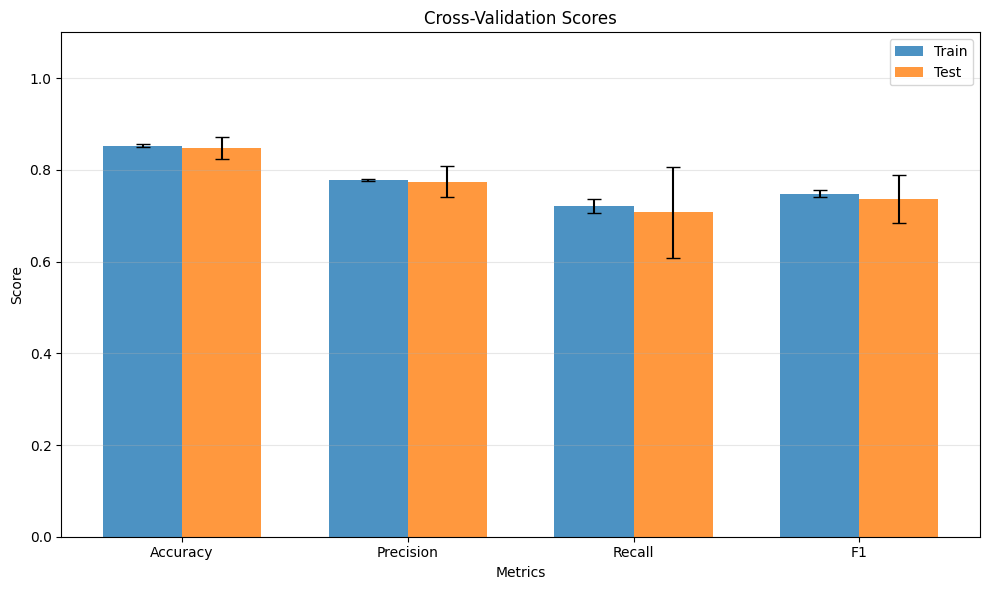

In [60]:
# クロスバリデーションスコアの可視化
metrics = ['accuracy', 'precision', 'recall', 'f1']
train_means = [cv_results[f'train_{m}'].mean() for m in metrics]
test_means = [cv_results[f'test_{m}'].mean() for m in metrics]
train_stds = [cv_results[f'train_{m}'].std() for m in metrics]
test_stds = [cv_results[f'test_{m}'].std() for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, train_means, width, yerr=train_stds, 
        label='Train', alpha=0.8, capsize=5)
plt.bar(x + width/2, test_means, width, yerr=test_stds, 
        label='Test', alpha=0.8, capsize=5)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Cross-Validation Scores')
plt.xticks(x, [m.capitalize() for m in metrics])
plt.legend()
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 6. 学習曲線

### 学習曲線とは

訓練データサイズを変えながら、モデルの性能がどう変化するかを示す曲線です。

**学習曲線から分かること:**
- 過学習の有無
- データ量が十分か
- モデルの複雑さは適切か

### 3つのパターン

#### 1. 過学習（Overfitting）
- **特徴**: 訓練スコアは高いが、検証スコアとの差が大きい
- **原因**: モデルが複雑すぎる、データが少ない
- **対策**: 正則化、モデルの簡略化、データの追加

#### 2. 学習不足（Underfitting）
- **特徴**: 訓練スコアも検証スコアも低い
- **原因**: モデルが単純すぎる、特徴量が不足
- **対策**: モデルの複雑化、特徴量の追加

#### 3. 良好な状態（Good Fit）
- **特徴**: 両スコアが高く、差が小さい
- **対策**: 現状維持、微調整

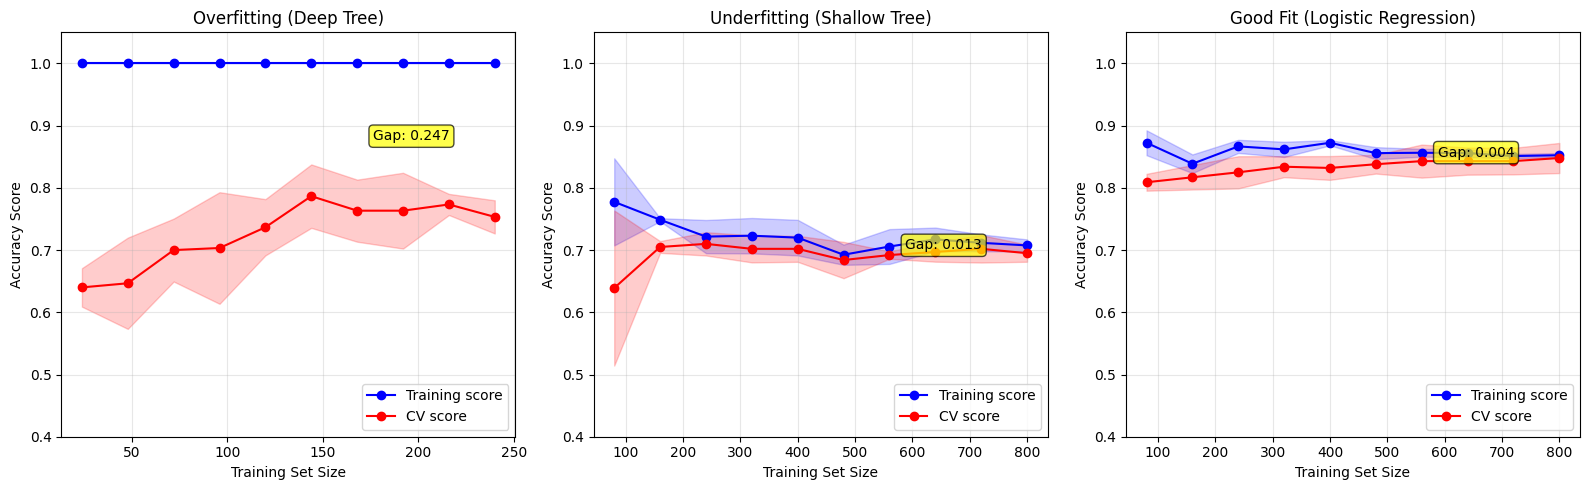

【3パターンの比較】

1. 過学習 (Overfitting):
   - 訓練スコアは高い（≈1.0）が、検証スコアとの差が大きい
   - データを増やすと検証スコアが改善する可能性がある

2. 学習不足 (Underfitting):
   - 訓練スコアも検証スコアも低い
   - データを増やしても改善しにくい → モデルの複雑化が必要

3. 良好な状態 (Good Fit):
   - 両スコアが高く、差が小さい
   - データ量も適切


In [61]:
from sklearn.tree import DecisionTreeClassifier

# 3パターンの学習曲線を比較するためのデータとモデルを準備

# 分類データの準備
X_lc, y_lc = make_classification(
    n_samples=1000, n_features=20, n_informative=10, n_redundant=5,
    n_classes=2, weights=[0.7, 0.3], random_state=42
)

# 3つのシナリオを設定
scenarios = [
    {
        'name': 'Overfitting (Deep Tree)',
        'model': DecisionTreeClassifier(max_depth=None, random_state=42),  # 制限なしの深い木
        'data_size': 300,  # 少ないデータ
        'color_train': 'blue',
        'color_test': 'red'
    },
    {
        'name': 'Underfitting (Shallow Tree)',
        'model': DecisionTreeClassifier(max_depth=1, random_state=42),  # 深さ1の浅い木
        'data_size': 1000,
        'color_train': 'blue',
        'color_test': 'red'
    },
    {
        'name': 'Good Fit (Logistic Regression)',
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'data_size': 1000,
        'color_train': 'blue',
        'color_test': 'red'
    }
]

# 3つのパターンを可視化
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, scenario in zip(axes, scenarios):
    # データサイズに応じてサブセットを使用
    n = scenario['data_size']
    X_sub, y_sub = X_lc[:n], y_lc[:n]
    
    # 学習曲線の計算
    train_sizes, train_scores, test_scores = learning_curve(
        scenario['model'], X_sub, y_sub, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )
    
    # 平均と標準偏差
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # プロット
    ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                    alpha=0.2, color='blue')
    ax.plot(train_sizes, test_mean, 'o-', color='red', label='CV score')
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, 
                    alpha=0.2, color='red')
    
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('Accuracy Score')
    ax.set_title(scenario['name'])
    ax.legend(loc='lower right')
    ax.set_ylim(0.4, 1.05)
    ax.grid(True, alpha=0.3)
    
    # ギャップをアノテーション
    gap = train_mean[-1] - test_mean[-1]
    ax.annotate(f'Gap: {gap:.3f}', 
                xy=(train_sizes[-1], (train_mean[-1] + test_mean[-1])/2),
                xytext=(-60, 0), textcoords='offset points',
                fontsize=10, ha='center',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

print("【3パターンの比較】")
print()
print("1. 過学習 (Overfitting):")
print("   - 訓練スコアは高い（≈1.0）が、検証スコアとの差が大きい")
print("   - データを増やすと検証スコアが改善する可能性がある")
print()
print("2. 学習不足 (Underfitting):")
print("   - 訓練スコアも検証スコアも低い")
print("   - データを増やしても改善しにくい → モデルの複雑化が必要")
print()
print("3. 良好な状態 (Good Fit):")
print("   - 両スコアが高く、差が小さい")
print("   - データ量も適切")

## 7. まとめ

### 本ノートブックで学んだこと

1. **分類評価指標**
   - Accuracy、Precision、Recall、F1スコア
   - それぞれの使い分け

2. **混同行列**
   - TP、TN、FP、FNの理解
   - 誤り のタイプの分析

3. **ROC曲線とAUC**
   - 分類器の性能可視化
   - 閾値の調整

4. **回帰評価指標**
   - MSE、RMSE、MAE、R²
   - 残差分析

5. **クロスバリデーション**
   - k-Fold CV
   - より信頼性の高い評価

6. **学習曲線**
   - 過学習/学習不足の検出
   - データ量の十分性の確認

### 評価指標の選び方

**分類問題:**
- バランスの取れたデータ → Accuracy
- 不均衡データ → F1、AUC
- 偽陽性を減らしたい → Precision
- 偽陰性を減らしたい → Recall

**回帰問題:**
- 一般的な用途 → RMSE
- 外れ値に頑健 → MAE
- モデルの説明力 → R²

### 次のステップ

- Notebook 04以降で具体的なモデルを学ぶ
- 実際のデータセットで評価を実践
- より高度な評価手法を探求